In [12]:
from torch import nn
import numpy as np
import torch
from torch.distributions.normal import Normal
import torch.optim as optim
import torch.utils.data

zeros = torch.zeros(1, 129, 8)
zeros = zeros.unsqueeze(0)
print(zeros.size())
zeroPadding = nn.ZeroPad2d((0, 0, 4, 4))
x = zeroPadding(zeros)
print(x.size())
conv = nn.Conv1d(1, 18, kernel_size=(9,8), padding='valid', bias=False)
x = conv(x)
print(x.size())
relu = nn.ReLU()
x = relu(x)
print(x.size())
bn = nn.BatchNorm2d(num_features=18)
x = bn(x)
print(x.size())

torch.Size([1, 1, 129, 8])
torch.Size([1, 1, 137, 8])
torch.Size([1, 18, 129, 1])
torch.Size([1, 18, 129, 1])
torch.Size([1, 18, 129, 1])


## Preprocessing Data

### Show a file

In [2]:
from preprocess import process_wav
import IPython

cleanvoice = "G:/Projects/2022-2023/ConvDenoiser/dataset/solovoice/common_voice_en_34919201.mp3"
ambience = "G:/Projects/2022-2023/ConvDenoiser/dataset/soloambience/105029-7-1-9.wav"

outputs = process_wav((cleanvoice, ambience))
f0 = outputs[0]
sp = outputs[1]
code_sp = outputs[2]
ap = outputs[3]
code_ap = outputs[4]
cAudioSamples = outputs[10]
samplerate = outputs[11]
nAudioSamples = outputs[13]


print("Clean audio: ")
IPython.display.display(IPython.display.Audio(cAudioSamples, rate=samplerate))
print("Noisy audio: ")
IPython.display.display(IPython.display.Audio(nAudioSamples, rate=samplerate))
print("Noisy F0: ")
print("Noisy SP: ")
print("Noisy Coded SP: ")
print("Noisy AP: ")
print("Noisy Coded AP: ")

IntSlider(value=7, description='Cats:', max=10)

Text(value='Hello World', description='String:', placeholder='Type something')

Hello World


### Preprocess a bunch of files

In [1]:
from preprocess import startProcessing

voicefolder = "H:/Projects/2022-2023/ConvDenoiser/dataset/voice2/"
noisefolder = "H:/Projects/2022-2023/ConvDenoiser/dataset/ambience2/"
exportfolder = "H:/Projects/2022-2023/ConvDenoiser/dataset/output2/"
savepathy = ""

startProcessing(savepathy, voicefolder, noisefolder, exportfolder, 'All')

Number of cpu's :  8


100%|██████████| 5/5 [00:55<00:00, 11.14s/it]



Enjoy your freshly processed files


Make and test model

In [1]:
from SPDenoiser import SPDenoiser, SPDataset
import torch
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader

learning_rate = 1e-3
batch_size = 64
epochs = 50
loss_fn = torch.nn.MSELoss()
device='cuda'
input = torch.zeros(60, 8)
input = input.unsqueeze(2)
input = input.unsqueeze(0)
print(input.size())

spdenoiser = SPDenoiser(60, 8, device)
spdenoiser.to(device)
spdataset = SPDataset("G:/Projects/2022-2023/ConvDenoiser/dataset/output/sp/", "G:/Projects/2022-2023/ConvDenoiser/dataset/output/csp/")
# sptestdataset = SPDataset("H:/Projects/2022-2023/ConvDenoiser/dataset/output/testsp/", "H:/Projects/2022-2023/ConvDenoiser/dataset/output/testcsp/")
spdataloader = DataLoader(spdataset, batch_size=256, shuffle=True)
# sptestdataloader = DataLoader(sptestdataset, batch_size=64, shuffle=True)

optimizer=torch.optim.Adam(spdenoiser.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
lossy = 0
step = 0

for epoch in range(epochs):
    lossy = 0
    step = 0
    with tqdm(enumerate(spdataloader),desc=f"Training. Epoch: {epoch}. Loss for step {step}: {lossy}") as t:
        for steppy, (x_train,y_train) in t:
            step = steppy
            x_train.double().to(device)
            y_train.double().to(device)

            # print(x_train.size())

            output = spdenoiser(x_train)
            # print("Output: ", output.size())
            # print("Y train: ", y_train.size())

            loss= loss_fn(output.to(device),y_train.to(device))
            lossy += loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if step%300==0:

            #     with torch.no_grad():
            #         accuracy=0
            #         loss=0
            #         for stepTest, (x_test,y_test) in tqdm(enumerate(sptestdataloader),desc="Validation"):
            #             x_test.double().to(device)
            #             y_test.double().to(device)
                        
            #             output = spdenoiser(x_test)
            #             accuracy+=calc_accuracy(output,y_test)*100
            #             loss+= lossFunction(output,y_test).item()
            #             if stepTest>200:
            #                 break

            t.set_description(f"Training. Epoch: {epoch}. Average loss for step {step}: {lossy / step}")
    

# input = torch.zeros(60, 8)
# input = input.unsqueeze(2)
# input = input.unsqueeze(0)
# print(input.size())

c:\Users\woute\.conda\envs\2Diff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 60, 8, 1])
Directories:  G:/Projects/2022-2023/ConvDenoiser/dataset/output/sp/ | G:/Projects/2022-2023/ConvDenoiser/dataset/output/csp/
Noisy file amount:  442
Clean file amount:  442


Loading files to dataset: 100%|██████████| 442/442 [00:01<00:00, 372.32it/s]
Training. Epoch: 0. Loss for step 0: 0: 0it [00:00, ?it/s]c:\Users\woute\.conda\envs\2Diff\lib\site-packages\torch\nn\modules\conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:896.)
  return F.conv2d(input, weight, bias, self.stride,
Training. Epoch: 0. Average loss for step 1769: 0.0014375553000718355: : 1770it [00:50, 35.35it/s]
Training. Epoch: 1. Average loss for step 1769: 0.00038102042162790895: : 1770it [00:48, 36.59it/s]
Training. Epoch: 2. Average loss for step 1769: 0.00030928925843909383: : 1770it [00:48, 36.44it/s]
Training. Epoch: 3. Average loss for step 1769: 0.00027779009542427957: : 1770it [00:48, 36.37it/s]
Training. Epoch: 4. Average loss for step 1769: 0.0002657547011040151: : 1770it [00:49, 35.56it/s] 
Training. Epoch: 5. Average los

KeyboardInterrupt: 

In [2]:
torch.save(spdenoiser.state_dict(), "./50EpochModel")

Testfile shape:  (948, 60)
(1, 60)
[]


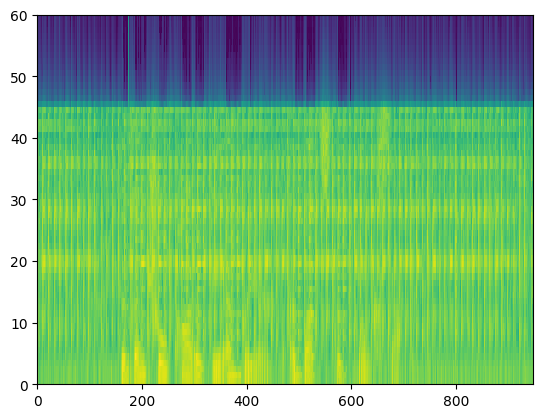

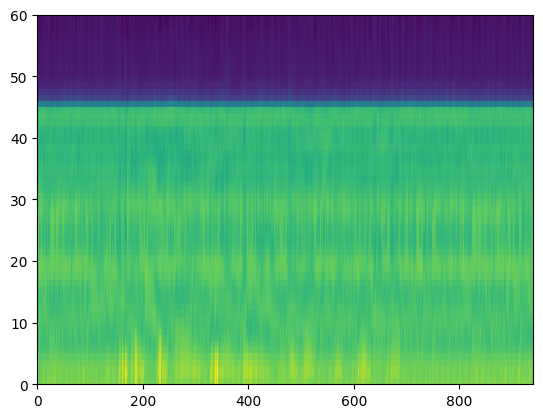

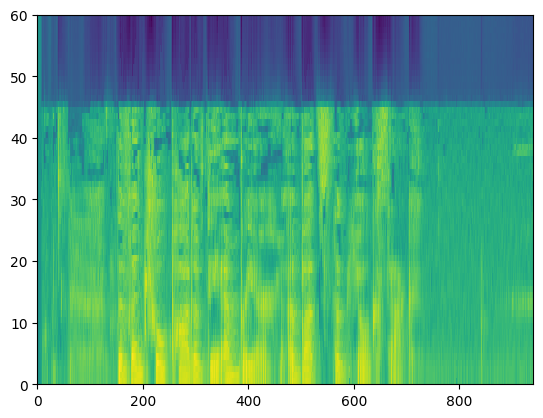

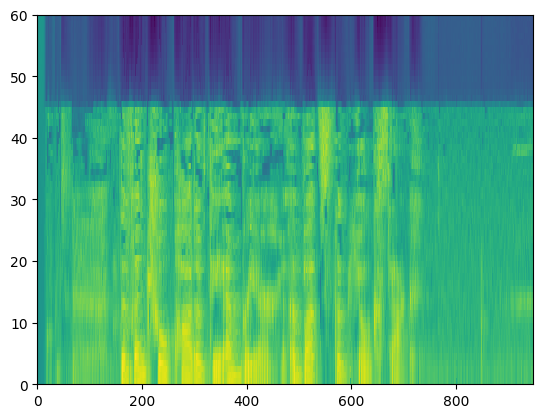

[[-0.05668763 -0.06085664 -0.0614794  ... -0.22669649 -0.22780386
  -0.22801624]
 [-0.05118615 -0.05161747 -0.05179325 ... -0.22749206 -0.22862431
  -0.22871734]
 [-0.0583665  -0.06075761 -0.05918235 ... -0.23007163 -0.2311013
  -0.23097983]
 ...
 [-0.05598873 -0.05770298 -0.05696543 ... -0.22729574 -0.22807018
  -0.22754341]
 [-0.05679396 -0.05895669 -0.05791262 ... -0.2277192  -0.22880594
  -0.22865158]
 [-0.05564064 -0.05704761 -0.05594956 ... -0.22663029 -0.22789489
  -0.22808711]]
[[ -2.4268813  -2.3786733  -2.4921072 ... -24.812925  -24.724274
  -24.91676  ]
 [-11.969855  -12.029929  -12.256174  ... -63.25784   -63.758854
  -64.05434  ]
 [-11.645352  -11.73154   -12.004105  ... -62.172577  -62.434967
  -62.564465 ]
 ...
 [-11.956538  -12.137658  -12.170861  ... -63.89195   -64.248566
  -64.29815  ]
 [-11.527877  -11.645845  -11.6128845 ... -66.11131   -66.8271
  -66.99393  ]
 [ -8.1246     -7.945929   -8.339193  ... -31.833475  -31.652859
  -31.931805 ]]


In [5]:
import matplotlib.pyplot as plt

testfile = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output2/sp/common_voice_en_34919211.mp3_sp.npy").astype(np.float32)
realcleanfile = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output2/csp/common_voice_en_34919211.mp3_sp.npy").astype(np.float32)
apc = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output2/cap2/common_voice_en_34919211.mp3_ap.npy")
f0c = np.load("G:/Projects/2022-2023/ConvDenoiser/dataset/output2/f0c/common_voice_en_34919211.mp3_f0.npy")
# spc = np.load("H:/Projects/2022-2023/ConvDenoiser/dataset/output2/f0c/common_voice_en_34919211.mp3_sp.npy")
print('Testfile shape: ', np.shape(testfile))
# testfile = torch.nn.functional.normalize(torch.from_numpy(testfile))
# testfile = testfile.cpu().detach().numpy()

realcleanfile = torch.nn.functional.normalize(torch.from_numpy(realcleanfile))
realcleanfile = realcleanfile.cpu().detach().numpy()
testsamples = []

cleansamples = []
i = 0
while i < len(testfile) - 8:
    testsamples.append(testfile[i:i+8])
    cleansamples.append(realcleanfile[i:i+8])
    i += 1

print(np.shape(cleansamples[0][-1:]))
cleanfile = np.zeros((0,60))
realclean = np.zeros((0,60))
print(cleanfile)
k = 0
for sample in testsamples:
    sample = torch.from_numpy(sample).transpose(0,1).unsqueeze(0).unsqueeze(0)
    output = spdenoiser(sample)
    # print(output.size())
    output = output.squeeze(0).squeeze(0).transpose(0,1).cpu().detach().numpy()
    realclean = np.concatenate((realclean, cleansamples[k][-1:]), axis=0)
    # print('Output size: ', np.shape(output))
    cleanfile = np.concatenate((cleanfile, output), axis=0)
    # print('Cleanfile shape: ', np.shape(cleanfile))
    k += 1


# newinput = torch.squeeze(noisy, dim=0)
# print(newinput.size())

plt.pcolormesh(np.ndarray.transpose(testfile, (1,0)))
plt.show()

plt.pcolormesh(np.ndarray.transpose(cleanfile, (1,0)))
plt.show()

plt.pcolormesh(np.ndarray.transpose(realclean, (1,0)))
plt.show()

plt.pcolormesh(np.ndarray.transpose(realcleanfile,(1,0)))
plt.show()

print(cleanfile)
print(testfile)

In [32]:
genmax = np.max(cleanfile)
testfile = np.load("H:/Projects/2022-2023/ConvDenoiser/dataset/output2/sp/common_voice_en_34919211.mp3_sp.npy").astype(np.float32)
testmax = np.max(realcleanfile)
print(genmax)
print(testmax)
# print(cleanfile)
scaling = testmax / genmax

newclean = np.multiply(cleanfile, 10)

print(realcleanfile)
print(newclean)
print(np.max(newclean))


-0.023061752319335938
0.018006027
[[-0.1295989  -0.12906523 -0.12919669 ... -0.12911756 -0.1296764
  -0.1273868 ]
 [-0.12992337 -0.13025263 -0.1295459  ... -0.12861253 -0.12928528
  -0.12808871]
 [-0.12826087 -0.12900071 -0.12935461 ... -0.12981056 -0.12905332
  -0.1276185 ]
 ...
 [-0.06837224 -0.06812188 -0.06873603 ... -0.21351966 -0.21362624
  -0.21321851]
 [-0.06723318 -0.06730317 -0.06781723 ... -0.21321286 -0.2102958
  -0.21207894]
 [-0.09135571 -0.09097271 -0.09139711 ... -0.20305274 -0.20415705
  -0.20540914]]
[[-0.26208133 -0.27831245 -0.25850158 ... -1.17653213 -1.18979335
  -1.20087452]
 [-0.24177713 -0.26141193 -0.24626471 ... -1.1890614  -1.20360628
  -1.2105304 ]
 [-0.29899204 -0.33337571 -0.3107308  ... -1.17123358 -1.18105851
  -1.20408885]
 ...
 [-0.27924903 -0.32054394 -0.29414073 ... -1.19285442 -1.20120943
  -1.2142013 ]
 [-0.25324915 -0.29548071 -0.28913967 ... -1.19698077 -1.21024139
  -1.21835582]
 [-0.22490371 -0.25800956 -0.25335688 ... -1.19305126 -1.20565772


(948, 1025)


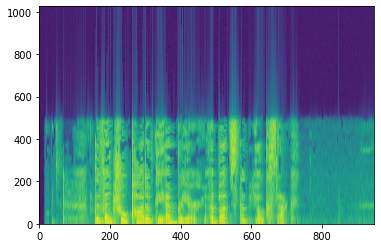

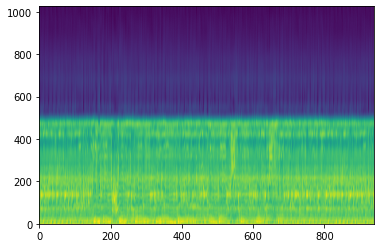

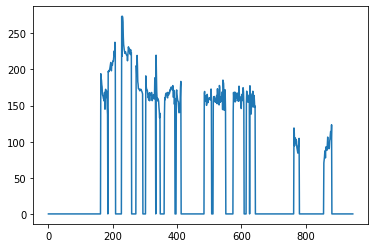

<IPython.lib.display.Audio object>


In [51]:
from preprocess import decode_harmonic
import pyworld as pw
import IPython.display as ipd
import soundfile as sf
from matplotlib.colors import LogNorm

ogspc = np.load("H:/Projects/2022-2023/ConvDenoiser/dataset/output2/csp2/common_voice_en_34919211.mp3_sp.npy")
print(np.shape(apc))
plt.pcolormesh(np.ndarray.transpose(ogspc, (1,0)),norm=LogNorm())
plt.show()

swag = np.ascontiguousarray(decode_harmonic(cleanfile, 2048))
plt.pcolormesh(np.ndarray.transpose(swag, (1,0)),norm=LogNorm())
plt.show()

plt.plot(f0c)
plt.show()

y = pw.synthesize(np.ascontiguousarray(f0c), np.ascontiguousarray(ogspc), np.ascontiguousarray(apc), 48000)

sound = ipd.Audio(y, rate = 44100, autoplay=True)
sf.write("./kaas.wav", y, 48000)
print(sound)

In [24]:
torch.nn.functional.normalize(torch.from_numpy(cleanfile), p=1.0)

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]], dtype=torch.float64)

In [2]:
import torch
input = torch.zeros(60, 8)
print(input[-1:].size())

torch.Size([1, 8])


c:\Users\woute\.conda\envs\Diffwave\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
